In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import sys
sys.path.append('..')
import scipy.stats as stats    

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt

import consts
importlib.reload(consts)

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

# pd set seed
np.random.seed(42)

In [2]:
df = pd.read_csv(consts.PATH_TO_DATA + 'full_pipeline_ok_filtered.csv')


In [3]:
icustays_filtered = pd.read_csv("..\\filtered\\filtered_icustays.csv")
inputevents = df.merge(icustays_filtered[["stay_id", "first_careunit"]], left_on="stay_id", right_on="stay_id")
inputevents_SICU_MICU = inputevents[inputevents["first_careunit"].isin([consts.MICU, consts.SICU])]
inputevents_SICU_MICU = inputevents_SICU_MICU.rename(columns={"first_careunit":"unit"})

In [4]:
import enum


def generate_equal_size_group(group):
    smaller_size = group["unit"].value_counts().min()
    smaller_gr = group["unit"].value_counts().index[group.unit.value_counts().argmin()]
    bigger_gr = group["unit"].value_counts().index[group.unit.value_counts().argmax()]
    subgroup1 = group[group["unit"] == smaller_gr]
    subgroup2 = group[group["unit"] == bigger_gr].sample(smaller_size, random_state=42)
    return pd.concat([subgroup1, subgroup2], axis=0)

def get_bp_sections(all_events_df):
    bp_sections = []
    for i, bp_range in enumerate(consts.BP_RANGES):
        bp_low, bp_high = bp_range 
        bp_section = inputevents_SICU_MICU[(inputevents_SICU_MICU["bp_val"] >= bp_low) & 
                                    (inputevents_SICU_MICU["bp_val"] <= bp_high) & 
                                    (inputevents_SICU_MICU["originalrate"] <= consts.MAXIMAL_ORIGINALRATE) & 
                                    (inputevents_SICU_MICU["originalrate"] >= consts.MINIMAL_ORIGINALRATE)]
        bp_section = generate_equal_size_group(bp_section)
        bp_sections.append(bp_section)
    return bp_sections

from math import dist
from distfit import distfit 
def fit_distribution(data, distribution):
    """
    # return score and params
    # params are: shape_hat, loc_hat, scale_hat 
    """
    dist = distfit(distr=distribution)
    dist.fit_transform(data)
    return dist.model["score"], dist.model["params"]

def rss_per_unit(all_bp_data, unit):
    bp_sections = get_bp_sections(all_bp_data[all_bp_data["unit"] == unit])
    rss_dict = {k:[] for k in consts.DISTRIBUTIONS}
    for distribution in consts.DISTRIBUTIONS:
        for section in bp_sections:
            score, params = fit_distribution(section["originalrate"], distribution)
            rss_dict[distribution].append(score)    
    rss_unit = pd.DataFrame(rss_dict)
    return rss_unit

def plot_unit_rss(rss_unit, unit_name):
    sns.set_palette("pastel")
    fig, ax = plt.subplots(1, 1, figsize = (20, 10))
    fig.tight_layout(pad=20)
    p = rss_unit.T.plot(kind="bar", stacked=True, ax=ax, fontsize=18)
    legend_labels = [f"BP:{r[0]}-{r[1]}" for r in consts.BP_RANGES]
    title = f"{unit_name} RSS results per distribution and BP group"
    plt.title(title, fontsize=24)
    plt.xticks(rotation=45)
    plt.legend(labels=legend_labels, loc=(1.04, 0), title="BP group", fontsize=14)
    plt.show()

# Choose the best distribution

In [5]:
import seaborn as sns
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

rss_MICU = rss_per_unit(inputevents_SICU_MICU, consts.MICU)
rss_SICU = rss_per_unit(inputevents_SICU_MICU, consts.SICU)

[distfit] >fit..
[distfit] >transform..
[distfit] >[pareto] [0.02 sec] [RSS: 809.528] [loc=-0.155 scale=0.165]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[pareto] [0.04 sec] [RSS: 506.818] [loc=-0.168 scale=0.176]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[pareto] [0.04 sec] [RSS: 426.44] [loc=-0.160 scale=0.170]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[pareto] [0.05 sec] [RSS: 432.99] [loc=-0.173 scale=0.179]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[pareto] [0.14 sec] [RSS: 394.318] [loc=-827.646 scale=827.654]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[pareto] [0.04 sec] [RSS: 476.676] [loc=-0.144 scale=0.154]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[di

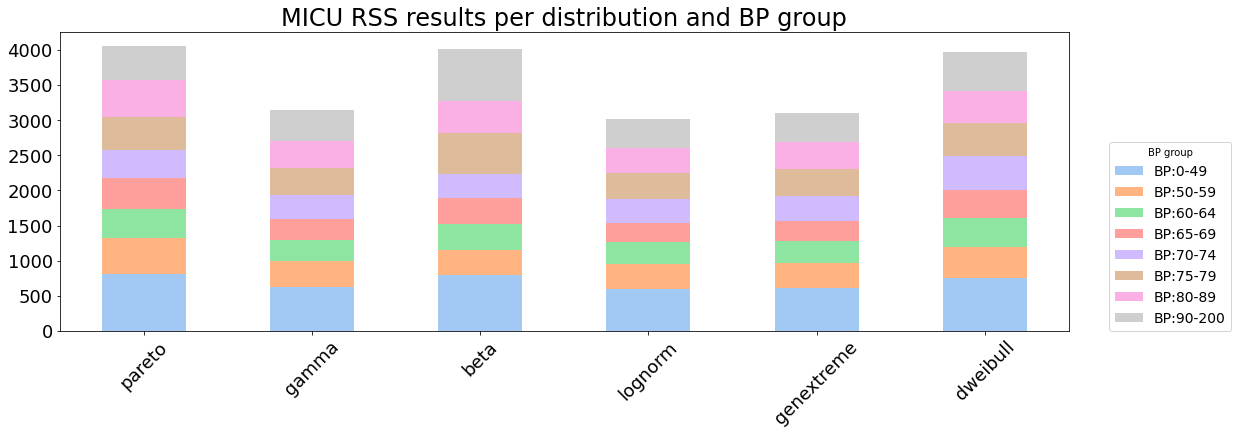

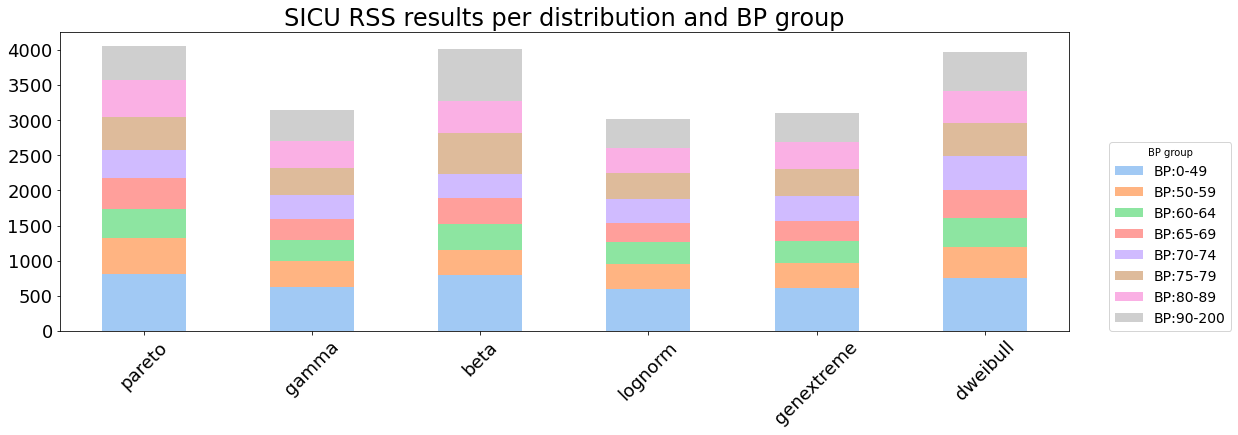

In [6]:
plot_unit_rss(rss_MICU, "MICU")
plot_unit_rss(rss_SICU, "SICU")

In [50]:
def plot_mle_curve(data, distribution, color, ax):
        score, params = fit_distribution(data, distribution)    
        shape_hat, loc_hat, scale_hat = params
        x = np.linspace(consts.MINIMAL_ORIGINALRATE, consts.MAXIMAL_ORIGINALRATE, 10000)
        y = stats.lognorm.pdf(x, s=shape_hat, scale=scale_hat, loc=loc_hat)
        ax.plot(x, y, linestyle="solid", color=color)

def plot_signle_plot(data, distribution, ax, bp_group):
    # find out number of samples per group
    number_of_samples = data.shape[0]/2
    #plot histogram
    sns.histplot(data=data[["originalrate", "unit"]],
                x="originalrate",
                bins=12, 
                binrange = (consts.MINIMAL_ORIGINALRATE,consts.MAXIMAL_ORIGINALRATE),
                hue="unit", 
                #kde=True, 
                stat="density",
                ax=ax,
                palette={consts.SICU : "red", consts.MICU : "black"},
                alpha=0.2)
    # plot the mle curve for selected distribution
    MICU_data = data[data["unit"] == consts.MICU]["originalrate"]
    SICU_data = data[data["unit"] == consts.SICU]["originalrate"]
    plot_mle_curve(SICU_data, distribution, "pink", ax)
    plot_mle_curve(MICU_data, distribution, "grey", ax)
    # apply kolmogorov smirnov test
    ks = stats.kstest(MICU_data, SICU_data)
    ks = stats.ks_2samp(MICU_data, SICU_data)
    # add title per BP group
    bp_low, bp_high = consts.BP_RANGES[bp_group][0], consts.BP_RANGES[bp_group][1]
    ax.set_title(f"BP: {bp_low}-{bp_high} \n {number_of_samples} samples per group \n kolomogorov smirnov p-val: {ks[1]:.4f} ", fontsize=14)
    ax.legend(labels=["MICU","SICU"])

def plot_all_groups(data, distribution):
    # set graph settings
    fig, axs = plt.subplots(4, 2)
    fig.set_size_inches(16, 16)
    fig.suptitle('Doses histogram per BP range group', fontsize=16)
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.92, 
                        wspace=0.5, 
                        hspace=0.5)
    # get data separeted to BP sections
    bp_sections = get_bp_sections(data)
    # plot graph per section
    for i, bp_section in enumerate(bp_sections):
        plot_signle_plot(bp_section, distribution, axs[i//2, i%2], i)
    # show graph
    plt.show()

[distfit] >fit..
[distfit] >transform..
[distfit] >[lognorm] [0.04 sec] [RSS: 859.415] [loc=-0.001 scale=0.082]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[lognorm] [0.03 sec] [RSS: 593.515] [loc=0.005 scale=0.071]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[lognorm] [0.04 sec] [RSS: 346.443] [loc=-0.002 scale=0.086]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[lognorm] [0.04 sec] [RSS: 491.034] [loc=0.001 scale=0.076]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[lognorm] [0.05 sec] [RSS: 307.724] [loc=-0.003 scale=0.086]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[distfit] >transform..
[distfit] >[lognorm] [0.05 sec] [RSS: 390.579] [loc=0.002 scale=0.075]
[distfit] >Compute confidence interval [parametric]
[distfit] >fit..
[d

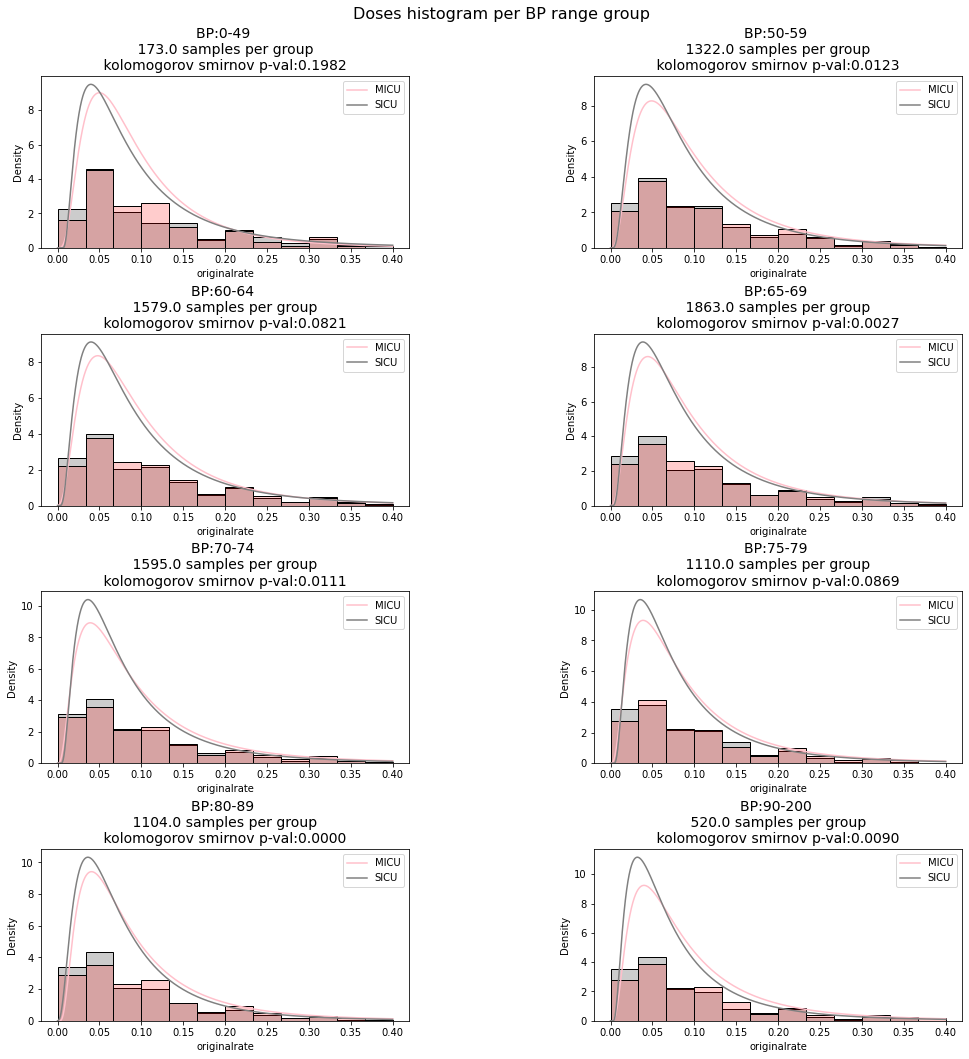

In [51]:
import enum
import seaborn as sns
import matplotlib.pyplot as plt

plot_all_groups(inputevents_SICU_MICU, "lognorm")
plt.show()